# Heavy precipitation analyses using Climate DT modeled data 2020-2040

Authors: Dr. Alen Berta (CGI), Cesare Rossi (CGI)

Licence: MIT

Reference:
https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide

Notes:
This example is intended for hands-on learning and does not constitute a comprehensive climatic study. This notebook will showcase the time series point analyses for 2 cities in Croatia (Zagreb as representative of continental climate and Dubrovnik as representative of Mediterranean climate). Service for analysing larger areas and exporting corresponding results in raster files will soon be available on Insula platform.


This notebook will provide the analyses relevant for detecting changes in precipitation due to climate change. The data used stem from Climate DT (Link) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide ).

The data used here are based on SSP3 NEMO model, representing next to worst scenario modeled in Shared Socio-Economic Pathways (SSPs) predicting the highest population development and lowest GDP amongst the considered scenarios in the near future, with global mean temperature rising between 3.85 and 4.55 C until 2100. (more info and photo credit https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change/)
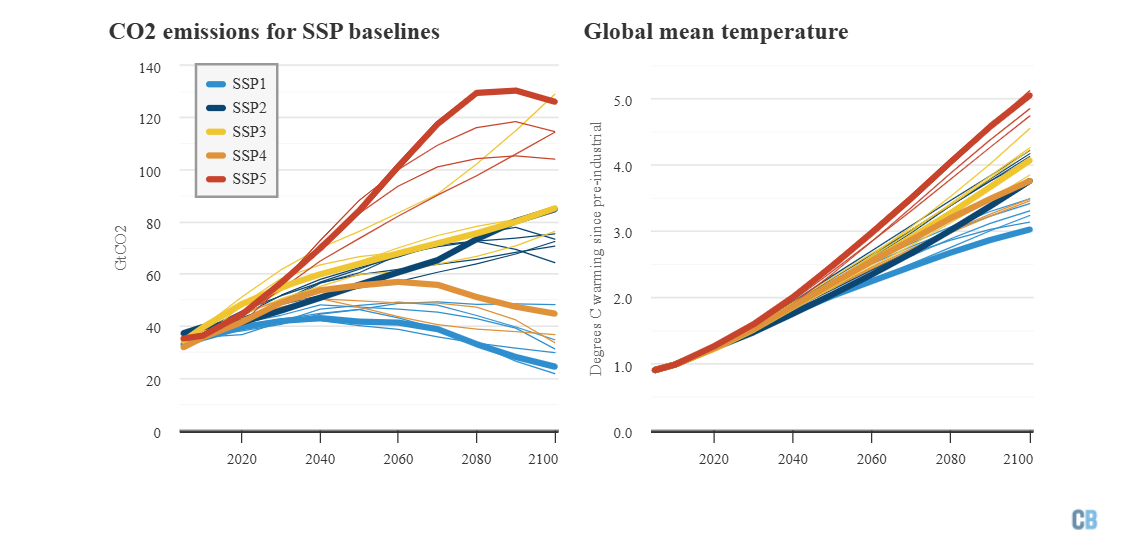

This notebook will provide the analyses relevant for detecting precipitation related changes due to climate change. The data used stem from Climate DT (https://destine.ecmwf.int/news/climate-change-adaptation-digital-twin-a-window-to-the-future-of-our-planet/) and will provide the calculation of some climate extreme indices (https://confluence.ecmwf.int/display/CKB/Climate+extreme+indices+and+heat+stress+indicators+derived+from+CMIP6+global+climate+projections%3A+Product+User+Guide).

Specifically we will present the approach to:

 1) Detect the number of heavy precipitation days per month (when there is >10mm of precipitation)
 2) Visualize the same index/indicator with the average values from 1990-2020 (extracted fromn ERA5) and 2021-2040 (extracted from the Climate DT)
 3) Visualize the standard deviation on monthly level concerning the averages from 1990-2020 and 2021-2040


## Data access

<div style="border: 2px solid #28a745; background-color: #d4edda; padding: 10px; border-radius: 5px;">
  <strong>💡 Tip:</strong> Provide here your Destination Earth credentials. Ensure that you requested and obtained an access policy upgrade, which is necessary to read the Climate DT data of this example. See <a href="https://platform.destine.eu/access-policy-upgrade/">https://platform.destine.eu/access-policy-upgrade</a>.
</div>

In [ ]:
%%capture cap
%run ./cacheb-authentication.py

In [2]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

## Data loading

In [3]:
import xarray as xr
import pandas as pd
import os
from utils import precipitation

In [4]:
data_prec = xr.open_dataset(
    "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
    storage_options={"client_kwargs":{"trust_env":"true"}},
    chunks={},
    engine="zarr",
)

In [5]:
data_prec

<xarray.Dataset> Size: 800TB
Dimensions:           (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 33kB -90.0 -89.96 -89.91 ... 89.96 90.0
  * longitude         (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23:...
Data variables: (12/34)
    blh               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    chnk              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    e                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ewss              (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    hcc               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ...                ...
    tp                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate            (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tsr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ttr               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10               (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [6]:
tp = data_prec.tp.astype("float32") *1000 #conversion from m to mm
tp.attrs["units"] = "mm"

In [7]:
zagreb_lat_lon=(45.8130,15.9772)
dubrovnik_lat_lon=(42.6507, 18.0944)

Select your year of interest between 2020 and 2040.

In [8]:
year_of_interest = "2035"

Decide whether you would like to perform a full analysis between 2020 and 2040.

In [9]:
full_2020_2040_analysis = False # If True, the analysis is performed against the whole period, then comparing it to the year_of_interest

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning:</strong> The computation time for one city/pixel/point for 2020-2040 might require 1.5 hours or more. Therefore, <b>for initial experiments, we suggest keeping the variable full_2020_2040_analysis set to False.</b>
</div>

In [10]:
# Select the data for Zagreb and Dubrovnik
tp_zagreb = tp.sel(latitude=zagreb_lat_lon[0], longitude=zagreb_lat_lon[1], method='nearest')
tp_dubrovnik = tp.sel(latitude=dubrovnik_lat_lon[0], longitude=dubrovnik_lat_lon[1], method='nearest')

if not full_2020_2040_analysis:
    # Subset the data for a given year
    tp_zagreb = tp_zagreb.sel(time=year_of_interest)
    tp_dubrovnik = tp_dubrovnik.sel(time=year_of_interest)

In [11]:
# Assuming 'tp_zagreb' and 'tp_dubrovnik' are your xarray DataArrays containing the precipitation data
thresholds = [10] # select 1, 10 or 20

# Summarize the precipitation data for Zagreb
summary_zagreb, monthly_summary_zagreb = precipitation.summarize_precipitation(tp_zagreb, thresholds)

# Summarize the precipitation data for Dubrovnik
summary_dubrovnik, monthly_summary_dubrovnik = precipitation.summarize_precipitation(tp_dubrovnik, thresholds)

<div style="border: 2px solid #f5c518; background-color: #fff3cd; padding: 10px; border-radius: 5px;">
  <strong>⚠️ Warning: </strong>The following cell usually takes <b>3 minutes</b> for each city/pixel/point. <b>If the variable full_2020_2040_analysis is set to True it might require 1.5 hour or more for one city/pixel/point.</b>
</div>

In [12]:
# Convert the monthly summaries to pandas DataFrames for easier viewing
%time monthly_summary_zagreb_df = monthly_summary_zagreb.to_dataframe()
%time monthly_summary_dubrovnik_df = monthly_summary_dubrovnik.to_dataframe()

CPU times: user 1min 15s, sys: 29.5 s, total: 1min 45s
Wall time: 5min 39s
CPU times: user 47.1 s, sys: 21.1 s, total: 1min 8s
Wall time: 2min 26s


In [13]:
# Save the results - this is useful later in case you would like to skip to the computation step above and play with the data
csv_directory = "csv"
if not os.path.exists(csv_directory):
    os.makedirs(csv_directory)
    
monthly_summary_zagreb_df.to_csv(f'{csv_directory}/Precipitation_monthly_counts_Zagreb.csv', index=True, chunksize=100)
monthly_summary_dubrovnik_df.to_csv(f'{csv_directory}/Precipitation_monthly_counts_Dubrovnik.csv', index=True, chunksize=100)

Read back the CSVs and use ERA5 data as a reference:

In [14]:
monthly_summary_zagreb_df = pd.read_csv(f'{csv_directory}/Precipitation_monthly_counts_Zagreb.csv', index_col=0, parse_dates=True)
monthly_summary_dubrovnik_df = pd.read_csv(f'{csv_directory}/Precipitation_monthly_counts_Dubrovnik.csv', index_col=0, parse_dates=True)

reference_directory = "reference"
monthly_summary_dubrovnik_df_era5 = pd.read_csv(f'{reference_directory}/Precipitation_monthly_counts_Dubrovnik_ERA5.csv', index_col=0, parse_dates=True)
monthly_summary_zagreb_df_era5 = pd.read_csv(f'{reference_directory}/Precipitation_monthly_counts_Zagreb_ERA5.csv', index_col=0, parse_dates=True)

## Heavy Precipitation Days per Month (with precipitation more than 10mm)

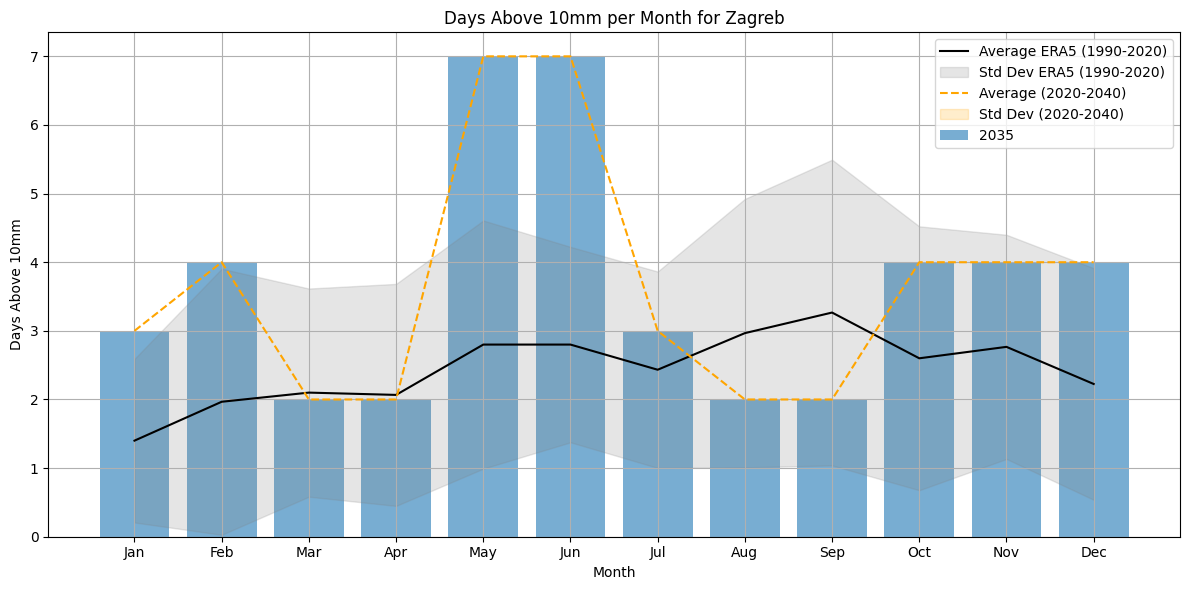

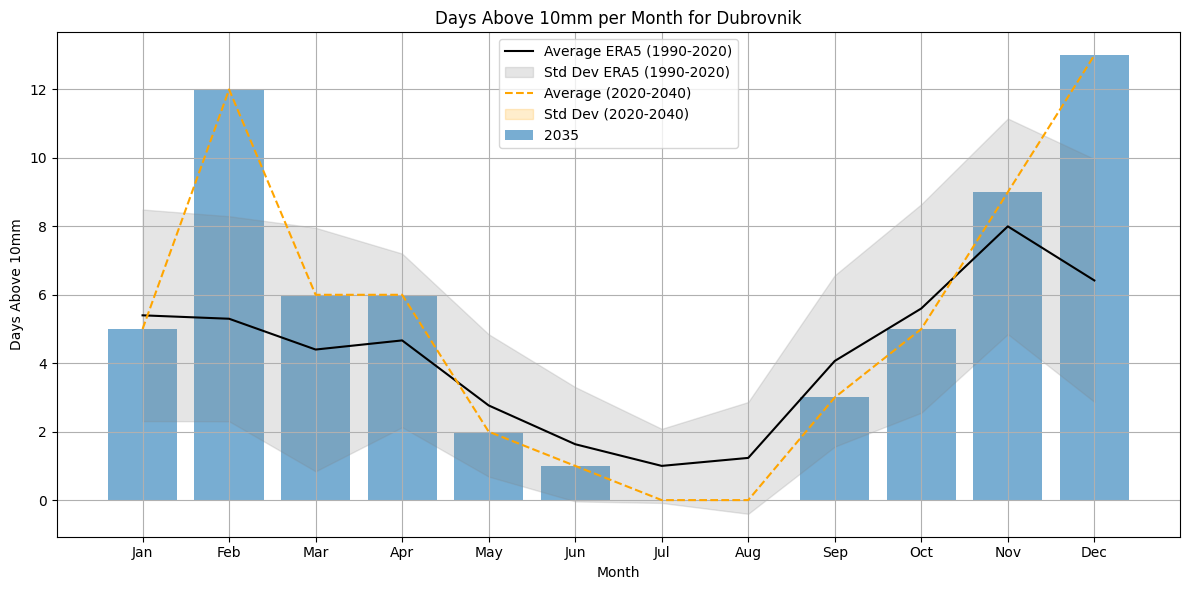

In [15]:
# Extract data for the year of interest
data_selected_zagreb = monthly_summary_zagreb_df[monthly_summary_zagreb_df.index.year == int(year_of_interest)]
data_selected_dubrovnik = monthly_summary_dubrovnik_df[monthly_summary_dubrovnik_df.index.year == int(year_of_interest)]

# Calculate the average and std for the whole period and for the ERA5 data
monthly_summary_zagreb_df['month'] = monthly_summary_zagreb_df.index.month
monthly_summary_zagreb_df_era5['month'] = monthly_summary_zagreb_df_era5.index.month

avg_zagreb = monthly_summary_zagreb_df.groupby('month')['days_above_10mm'].mean()
std_zagreb = monthly_summary_zagreb_df.groupby('month')['days_above_10mm'].std()

avg_zagreb_era5 = monthly_summary_zagreb_df_era5.groupby('month')['days_above_10mm'].mean()
std_zagreb_era5 = monthly_summary_zagreb_df_era5.groupby('month')['days_above_10mm'].std()
   
monthly_summary_dubrovnik_df['month'] = monthly_summary_dubrovnik_df.index.month
monthly_summary_dubrovnik_df_era5['month'] = monthly_summary_dubrovnik_df_era5.index.month

avg_dubrovnik = monthly_summary_dubrovnik_df.groupby('month')['days_above_10mm'].mean()
std_dubrovnik = monthly_summary_dubrovnik_df.groupby('month')['days_above_10mm'].std()

avg_dubrovnik_era5 = monthly_summary_dubrovnik_df_era5.groupby('month')['days_above_10mm'].mean()
std_dubrovnik_era5 = monthly_summary_dubrovnik_df_era5.groupby('month')['days_above_10mm'].std()
 
# Plot the data for Zagreb - Days Above 10mm
precipitation.plot_data(
    city_name="Zagreb",
    data_selected=data_selected_zagreb,
    avg_data=avg_zagreb,
    std_data=std_zagreb,
    avg_era5=avg_zagreb_era5,
    std_era5=std_zagreb_era5,
    yoi=year_of_interest,
    ylabel="Days Above 10mm",
    column_name="days_above_10mm"
)

# Plot the data for Dubrovnik - Days Above 10mm
precipitation.plot_data(
    city_name="Dubrovnik",
    data_selected=data_selected_dubrovnik,
    avg_data=avg_dubrovnik,
    std_data=std_dubrovnik,
    avg_era5=avg_dubrovnik_era5,
    std_era5=std_dubrovnik_era5,
    yoi=year_of_interest,
    ylabel="Days Above 10mm",
    column_name="days_above_10mm"
)

<div style="border: 2px solid #909090; background-color: #e1e1e1; padding: 10px; border-radius: 5px;">

As a reference, the following graphs present the results of the full computation (i.e., <i>full_2020_2040_analysis = True</i>), comparing the year 2035 with the entire 2020–2040 range.

<table>
<tr>
    <th><img src="images/heavy_rain_output_0.png" width="600"></th>
    <th><img src="images/heavy_rain_output_1.png" width="600"></th>
</table>
</div>